# Exercise-4: Transfer Learning with Pre-trained CNN

Use a pre-trained convolutional neural network (CNN) as a feature extractor and fine-tune a classifier on a subset of the CIFAR-10 dataset. Set random seeds to 42. Follow the configuration below:

- Load CIFAR-10 and normalize pixel values to [0,1]
- Use only the first 2000 training samples and first 500 test samples
- Load MobileNetV2 from tensorflow.keras.applications, with include_top=False and weights='imagenet'
- Freeze all layers of the pre-trained base
- Add a classifier on top:
  - GlobalAveragePooling2D
  - Dense layer with 128 neurons, ReLU activation
  - Dropout: 0.2
  - Output layer: 10 neurons with softmax
- Optimizer: Adam, learning_rate = 0.001
- Loss: sparse_categorical_crossentropy
- epochs = 5, batch_size = 32

## Q4.1 Report the test accuracy of the model.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2


# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Use only the first 2000 training samples and 500 test samples
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:500]
y_test = y_test[:500]

# Resize images from 32x32 to 224x224 for MobileNetV2
x_train = tf.image.resize(x_train, [224, 224])
x_test = tf.image.resize(x_test, [224, 224])

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Freeze the base model
base_model.trainable = False

dropout_rate = 0.2
# Add a classifier on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
# Global average pooling layer
x = layers.GlobalAveragePooling2D()(x)
# Dense hidden layer with 128 units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# 0.2 dropout rate
x = layers.Dropout(0.2)(x)
# Softmax output layer for 10 classes
outputs = layers.Dense(10, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configure training parameters
batch_size = 32
epochs = 5

# Train the model
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=0.2,
                    verbose=1)
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')



/var/folders/_0/wyv54m_x00gfpfh5p7_nchbw0000gn/T/ipykernel_70165/859600164.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.5125 - loss: 1.4571 - val_accuracy: 0.6800 - val_loss: 0.9115
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.7300 - loss: 0.7770 - val_accuracy: 0.7050 - val_loss: 0.8427
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.7700 - loss: 0.6287 - val_accuracy: 0.7050 - val_loss: 0.8447
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.8388 - loss: 0.4730 - val_accuracy: 0.7050 - val_loss: 0.8171
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.8744 - loss: 0.3875 - val_accuracy: 0.7125 - val_loss: 0.8257
Test accuracy: 0.7000


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


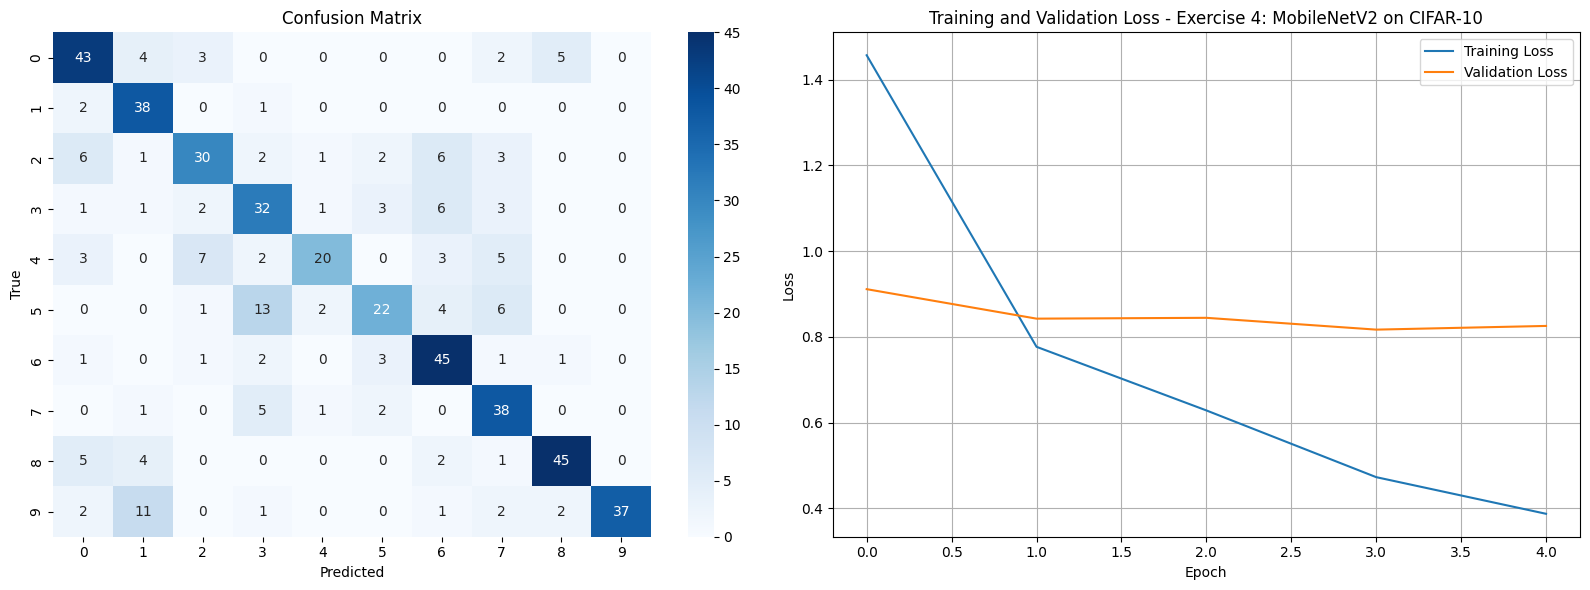

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Generate predictions and confusion matrix
y_pred = np.argmax(model.predict(x_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix')

# --- Plot 2: Training and Validation Loss ---
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss - Exercise 4: MobileNetV2 on CIFAR-10')
axes[1].legend()
axes[1].grid(True)

# Adjust spacing
plt.tight_layout()
plt.show()